# GLM-PCA analysis of single-cell methylome data



Starting from the publicly available single-cell methylation data from [snmCATseq](https://www.sciencedirect.com/science/article/pii/S2666979X22000271?via%3Dihub) , we re-processed a subset of the data to extract methlated/unmethylated reads in small genomics bins (10kb), yielding non-Gaussian data (see tutorial on preprocessing [here](https://sincei.readthedocs.io/en/latest/content/tutorials/snmCATseq_preprocessing.html)). 

This data was stored as pickle files `snmC2Tseq_eckerlab/10k_bin/processed_data_*_2024_06_13.pkl`, which we will import here.

Another file named `mmc5.xlsx` contains metadata for celltype identification.

The data is losely following a Beta distribution, and we thus employ GLM-PCA with Beta distribution to find a lower-dimension representation.


In [2]:
import os, scipy, tqdm, umap
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sincei.GLMPCA import GLMPCA

data_type = 'HCGN'

## Read data


Starting from the files provided in our figshare repository, the data needs to be first processed as demonstrated in "snmCATseq_prepcessing.ipynb". We here load the output.

In order to confirm whether glmPCA results help in identifying clusters of cells, we shall also load the celltype metadata provided in the Supplementary table 5 of the original manuscript.


In [3]:
# methylation (number of methylated covered)
df_cov = pd.read_pickle(
    './snmC2Tseq_eckerlab/10k_bin/processed_data_%s_2024_06_13.pkl'%(data_type),
)

X_data = df_cov.values
X_data = X_data[:,np.where(np.std(X_data, axis=0)>0.08)[0]] # Previously 0.08

In [4]:
# Metadata from the paper
metadata_df = pd.read_excel('./snmC2Tseq_eckerlab/mmc5.xlsx', sheet_name=1, header=1)

# Structure metadata
metadata_df['sample_idx'] = metadata_df['Sample'].apply(lambda x: '_'.join(x.split('_')[1:11]))
metadata_df = metadata_df.set_index('sample_idx')

X_data_index = ['_'.join(e.split('/')[-1].split('.')[0].split('_')[3:13]) for e in  df_cov.loc[data_type].index]
cell_labels = metadata_df.loc[X_data_index]

## Sincei: GLM-PCA

To aid in this analysis, we provide two Beta families within the glmPCA framework: **Beta** and **SigmoidBeta**. 

SigmoidBeta employs a logit-transformed saturated parameters, which removes all optimisation constraints and is therefore much more stable.


Several hyper-parameters are hard-coded, but do not vastly influence the analysis. The only hyper-parameter which can change results fondamentally is the learning rate. 2.5 is a good choice for sigmoid_beta, but this needs to be changed for other distributions.

In [5]:
eps = 1e-5
n_pc = 20
family = 'sigmoid_beta'

clf = GLMPCA(
    n_pc=n_pc, 
    family=family, 
    n_jobs=5, 
    max_iter=500,
    learning_rate=10., 
)

Beta distribution not initialized yet


In [6]:
# Imputes zeros with mean
X_glm_data = X_data.copy()
for idx in tqdm.tqdm(range(X_data.shape[1])):
    non_zero_mean = X_glm_data[X_glm_data[:,idx] != 0,idx].mean()
    X_glm_data[X_glm_data[:,idx] == 0,idx] = non_zero_mean

clf.fit(torch.Tensor(X_glm_data))

 21%|███████████████████████████████▋                                                                                                                       | 21/100 [00:02<00:11,  7.02it/s]


CONVERGENCE AFTER 21 ITERATIONS
CONVERGENCE NOT REACHED
LEARNING RATE: 10.0


  0%|                                                                                                                                                                | 0/500 [00:00<?, ?it/s]/Users/Bhard002/programs/miniconda3/envs/sincei/lib/python3.8/site-packages/mctorch/nn/manifolds/stiefel.py:72: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  q, r = torch.qr(X + G)
  7%|███████████▏                                                                                                                                           | 37/500 [00:10<02:05,  3.68it/s]

	RESTART BECAUSE INF/NAN FOUND
LEARNING RATE: 5.0



  8%|████████████▍                                                                                                                                          | 41/500 [00:11<02:05,  3.67it/s]


  9%|█████████████▎                                                                                                                                         | 44/500 [00:12<02:06,  3.62it/s]

	RESTART BECAUSE INF/NAN FOUND
LEARNING RATE: 2.5




  0%|                                                                                                                                                                | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                       | 1/500 [00:00<02:15,  3.69it/s]

  0%|▌                                                                                                                                                       | 2/500 [00:00<02:15,  3.68it/s]

  1%|▉                                                                                                                                                       | 3/500 [00:00<02:15,  3.68it/s]

  1%|█▏                                                                                                                                                      | 4/500 [00:01<02:14,  3.69it/s]

  1%|█▌                                    

  8%|████████████▍                                                                                                                                          | 41/500 [00:11<02:05,  3.66it/s]

  8%|████████████▋                                                                                                                                          | 42/500 [00:11<02:04,  3.67it/s]

  9%|████████████▉                                                                                                                                          | 43/500 [00:11<02:05,  3.65it/s]

  9%|█████████████▎                                                                                                                                         | 44/500 [00:11<02:05,  3.64it/s]

  9%|█████████████▌                                                                                                                                         | 45/500 [00:12<02:04,  3.65it/s]

  9%|█████████████▉                          

 16%|████████████████████████▊                                                                                                                              | 82/500 [00:22<01:55,  3.61it/s]

 17%|█████████████████████████                                                                                                                              | 83/500 [00:22<01:55,  3.63it/s]

 17%|█████████████████████████▎                                                                                                                             | 84/500 [00:23<01:54,  3.64it/s]

 17%|█████████████████████████▋                                                                                                                             | 85/500 [00:23<01:53,  3.65it/s]

 17%|█████████████████████████▉                                                                                                                             | 86/500 [00:23<01:53,  3.66it/s]

 17%|██████████████████████████▎             

 25%|████████████████████████████████████▉                                                                                                                 | 123/500 [00:34<01:46,  3.54it/s]

 25%|█████████████████████████████████████▏                                                                                                                | 124/500 [00:34<01:45,  3.55it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 125/500 [00:34<01:46,  3.53it/s]

 25%|█████████████████████████████████████▊                                                                                                                | 126/500 [00:35<01:46,  3.53it/s]

 25%|██████████████████████████████████████                                                                                                                | 127/500 [00:35<01:46,  3.51it/s]

 26%|██████████████████████████████████████▍ 

 33%|█████████████████████████████████████████████████▏                                                                                                    | 164/500 [00:45<01:31,  3.66it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 165/500 [00:45<01:31,  3.66it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                    | 166/500 [00:45<01:31,  3.65it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 167/500 [00:46<01:31,  3.64it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                   | 168/500 [00:46<01:31,  3.65it/s]

 34%|████████████████████████████████████████

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 205/500 [00:56<01:27,  3.38it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                        | 206/500 [00:57<01:28,  3.33it/s]

 41%|██████████████████████████████████████████████████████████████                                                                                        | 207/500 [00:57<01:25,  3.42it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                       | 208/500 [00:57<01:23,  3.48it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                       | 209/500 [00:57<01:22,  3.53it/s]

 42%|████████████████████████████████████████

 49%|█████████████████████████████████████████████████████████████████████████▊                                                                            | 246/500 [01:08<01:09,  3.66it/s]

 49%|██████████████████████████████████████████████████████████████████████████                                                                            | 247/500 [01:08<01:08,  3.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                           | 248/500 [01:08<01:08,  3.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                           | 249/500 [01:08<01:08,  3.67it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 250/500 [01:09<01:08,  3.67it/s]

 50%|████████████████████████████████████████

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                | 287/500 [01:19<00:58,  3.66it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                               | 288/500 [01:19<00:58,  3.64it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                               | 289/500 [01:19<00:58,  3.62it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 290/500 [01:20<00:58,  3.61it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                              | 291/500 [01:20<00:57,  3.61it/s]

 58%|████████████████████████████████████████

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 328/500 [01:30<00:47,  3.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 329/500 [01:31<00:46,  3.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 330/500 [01:31<00:46,  3.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 331/500 [01:31<00:46,  3.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 332/500 [01:31<00:46,  3.65it/s]

 67%|████████████████████████████████████████

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 369/500 [01:41<00:35,  3.68it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 370/500 [01:42<00:35,  3.67it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 371/500 [01:42<00:35,  3.67it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 372/500 [01:42<00:34,  3.67it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 373/500 [01:43<00:34,  3.68it/s]

 75%|████████████████████████████████████████

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 410/500 [01:53<00:25,  3.57it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 411/500 [01:53<00:26,  3.32it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 412/500 [01:53<00:25,  3.42it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 413/500 [01:54<00:24,  3.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 414/500 [01:54<00:24,  3.54it/s]

 83%|████████████████████████████████████████

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 451/500 [02:04<00:13,  3.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 452/500 [02:04<00:13,  3.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 453/500 [02:05<00:12,  3.67it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 454/500 [02:05<00:12,  3.67it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 455/500 [02:05<00:12,  3.67it/s]

 91%|████████████████████████████████████████

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 492/500 [02:15<00:02,  3.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 493/500 [02:15<00:01,  3.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 494/500 [02:16<00:01,  3.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 495/500 [02:16<00:01,  3.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 496/500 [02:16<00:01,  3.66it/s]

 99%|████████████████████████████████████████

True

Text(0, 0.5, 'Training loss')

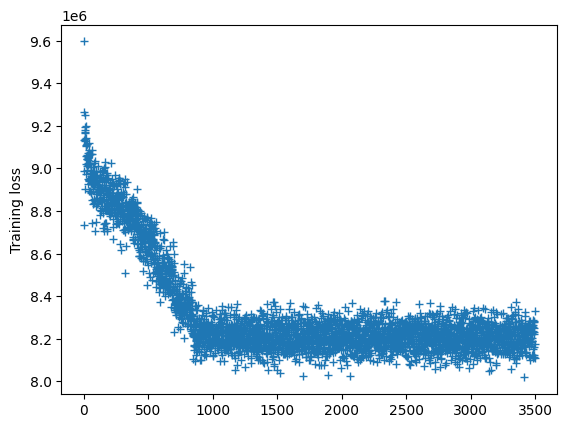

In [7]:
# Learning curves: needs to reach a plateau.
plt.plot(np.array(clf.loadings_learning_scores_).T, '+')
plt.ylabel('Training loss')

In [8]:
X_project = clf.transform(torch.Tensor(X_glm_data))

 21%|███████████████████████████████▋                                                                                                                       | 21/100 [00:02<00:11,  7.04it/s]

CONVERGENCE AFTER 21 ITERATIONS
CONVERGENCE NOT REACHED


### UMAP on GLM-PCA

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_epochs=1000, verbose=True)
Thu Jul 25 19:39:46 2024 Construct fuzzy simplicial set
Thu Jul 25 19:39:47 2024 Finding Nearest Neighbors
Thu Jul 25 19:39:47 2024 Finished Nearest Neighbor Search
Thu Jul 25 19:39:47 2024 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Jul 25 19:39:48 2024 Finished embedding


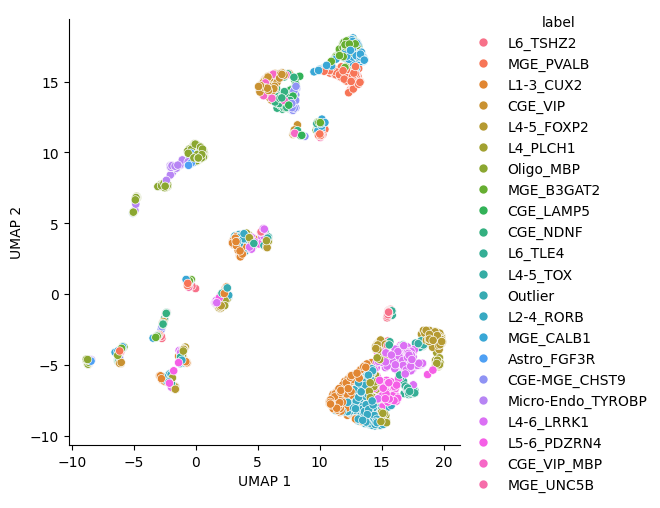

In [15]:
_umap_params = {'n_neighbors':15, 'min_dist': 0.3, 'n_epochs': 1000}

metric = 'cosine'

_umap_clf = umap.UMAP(metric=metric, verbose=True, **_umap_params)
umap_embeddings = pd.DataFrame(
    _umap_clf.fit_transform(X_project.detach().numpy()), 
    columns=['UMAP 1', 'UMAP 2']
).reset_index()
umap_embeddings['label'] = cell_labels['snmC2T-seq Baseline Cluster'].values

g = sns.relplot(data=umap_embeddings, x='UMAP 1', y='UMAP 2',hue='label')
figure_name = 'UMAP_glm_pca_%s_metric_%s_%s'%(
    n_pc, 
    metric,
    family
)

## Compare to regular SVD-based PCA.

In [13]:
pca_clf = PCA(n_pc).fit(X_data)
X_pca = pca_clf.transform(X_data)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_epochs=1000, verbose=True)
Thu Jul 25 19:39:54 2024 Construct fuzzy simplicial set
Thu Jul 25 19:39:55 2024 Finding Nearest Neighbors
Thu Jul 25 19:39:55 2024 Finished Nearest Neighbor Search
Thu Jul 25 19:39:55 2024 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Jul 25 19:39:56 2024 Finished embedding


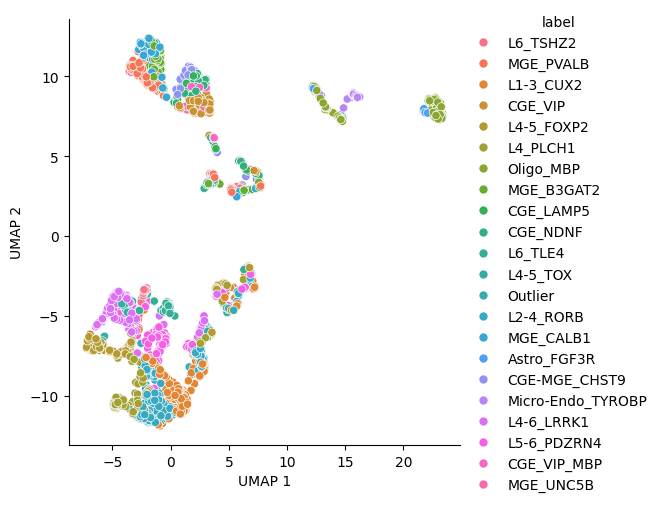

In [16]:
_umap_params = {'n_neighbors':15, 'min_dist': 0.3, 'n_epochs': 1000}

metric = 'cosine'
_umap_clf = umap.UMAP(metric=metric, verbose=True, **_umap_params)
umap_embeddings = pd.DataFrame(
    _umap_clf.fit_transform(X_pca), 
    columns=['UMAP 1', 'UMAP 2']
).reset_index()
umap_embeddings['label'] = cell_labels['snmC2T-seq Baseline Cluster'].values

g = sns.relplot(data=umap_embeddings, x='UMAP 1', y='UMAP 2',hue='label')

## Compare directions found by GLM-PCA and regular PCA
### Cosine similarity

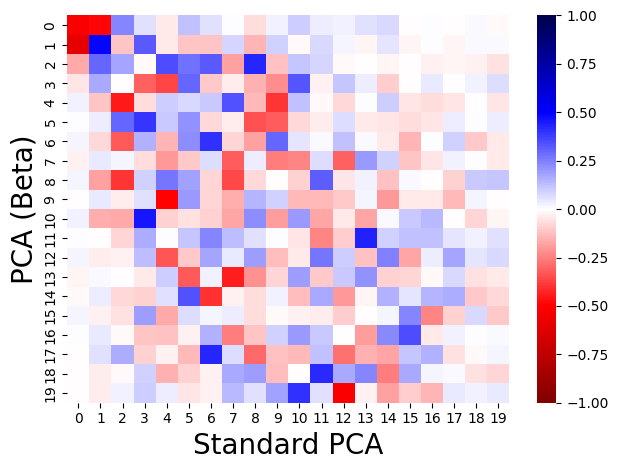

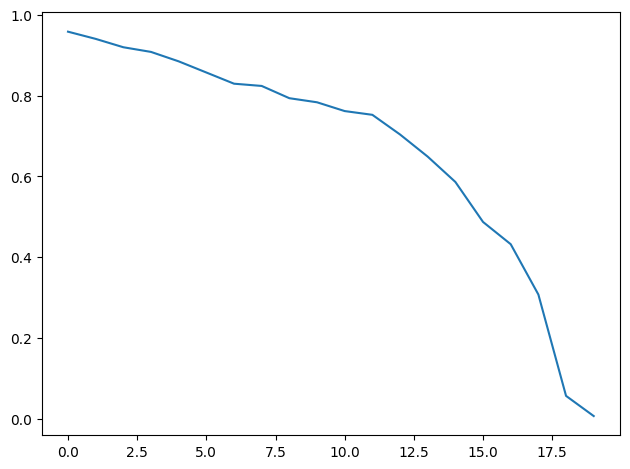

In [17]:
M = clf.saturated_loadings_.detach().numpy().T.dot(pca_clf.components_.T)
sns.heatmap(M, cmap='seismic_r', center=0, vmax=1, vmin=-1)
plt.ylabel('PCA (Beta)', fontsize=20)
plt.xlabel('Standard PCA', fontsize=20)
plt.tight_layout()
plt.show()

plt.plot(np.linalg.svd(M)[1])
plt.tight_layout()
plt.show()